In [1]:
import requests
import json

import pandas as pd
import numpy as np

import datetime
from math import floor,ceil

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# Get the Data

# Get current season fixtures and results from football data API
FOOTDATA_URL = 'http://api.football-data.org/v2/competitions/2021/matches'
API_TOKEN = 'YOUR_API_TOKEN' # Get a token from www.football-data.org

print('Getting',FOOTDATA_URL,'...')
response = requests.get(FOOTDATA_URL, headers={'X-Auth-Token':API_TOKEN})
raw_json = response.json()

# convert the json into pandas data frames
print('------------------')
print('Converting json to data frames:')
df_dict = {}
for key in raw_json.keys():
    print(key+'...', end='')
    try:
        df = pd.DataFrame(raw_json[key])
        df_dict[key] = df
        print('done.')
    except:
        # couldn't make a data frame, maybe its one list of values so try a series
        try:
            df = pd.Series(raw_json[key])
            df_dict[key] = df
            print('done.')
        except:
            print('ERROR!')
print('------------------')

# get the matches data
df = df_dict['matches']
df.head()

Getting http://api.football-data.org/v2/competitions/2021/matches ...
------------------
Converting json to data frames:
count...done.
filters...done.
competition...done.
matches...done.
------------------


,awayTeam,group,homeTeam,id,lastUpdated,matchday,referees,score,season,stage,status,utcDate
0,"{'id': 338, 'name': 'Leicester City FC'}",Regular Season,"{'id': 66, 'name': 'Manchester United FC'}",233028,2019-03-03T21:34:11Z,1,"[{'id': 11610, 'name': 'Andre Marriner', 'nati...","{'winner': 'HOME_TEAM', 'duration': 'REGULAR',...","{'id': 151, 'startDate': '2018-08-10', 'endDat...",REGULAR_SEASON,FINISHED,2018-08-10T19:00:00Z
1,"{'id': 73, 'name': 'Tottenham Hotspur FC'}",Regular Season,"{'id': 67, 'name': 'Newcastle United FC'}",233026,2019-03-03T21:34:11Z,1,"[{'id': 11551, 'name': 'Martin Atkinson', 'nat...","{'winner': 'AWAY_TEAM', 'duration': 'REGULAR',...","{'id': 151, 'startDate': '2018-08-10', 'endDat...",REGULAR_SEASON,FINISHED,2018-08-11T11:30:00Z
2,"{'id': 354, 'name': 'Crystal Palace FC'}",Regular Season,"{'id': 63, 'name': 'Fulham FC'}",233024,2019-03-03T21:34:11Z,1,"[{'id': 11575, 'name': 'Mike Dean', 'nationali...","{'winner': 'AWAY_TEAM', 'duration': 'REGULAR',...","{'id': 151, 'startDate': '2018-08-10', 'endDat...",REGULAR_SEASON,FINISHED,2018-08-11T14:00:00Z
3,"{'id': 61, 'name': 'Chelsea FC'}",Regular Season,"{'id': 394, 'name': 'Huddersfield Town AFC'}",233029,2019-03-03T21:34:11Z,1,"[{'id': 11443, 'name': 'Chris Kavanagh', 'nati...","{'winner': 'AWAY_TEAM', 'duration': 'REGULAR',...","{'id': 151, 'startDate': '2018-08-10', 'endDat...",REGULAR_SEASON,FINISHED,2018-08-11T14:00:00Z
4,"{'id': 397, 'name': 'Brighton & Hove Albion FC'}",Regular Season,"{'id': 346, 'name': 'Watford FC'}",233031,2019-03-03T21:34:11Z,1,"[{'id': 11567, 'name': 'Jonathan Moss', 'natio...","{'winner': 'HOME_TEAM', 'duration': 'REGULAR',...","{'id': 151, 'startDate': '2018-08-10', 'endDat...",REGULAR_SEASON,FINISHED,2018-08-11T14:00:00Z


In [14]:
# do some tidying up

# remove columns we don't need
df.drop(['group','lastUpdated','referees','season','stage'],axis=1, inplace=True)
df.set_index('id',inplace=True)

# extract team names from dictionaries
def extract_team(team_dict):
    return team_dict['name']

df['awayTeam'] = df['awayTeam'].apply(extract_team)
df['homeTeam'] = df['homeTeam'].apply(extract_team)

df['awayTeam'] = df['awayTeam'].str.replace('AFC','')
df['awayTeam'] = df['awayTeam'].str.replace('FC','')
df['awayTeam'] = df['awayTeam'].str.strip()

df['homeTeam'] = df['homeTeam'].str.replace('AFC','')
df['homeTeam'] = df['homeTeam'].str.replace('FC','')
df['homeTeam'] = df['homeTeam'].str.strip()

# convert date column to datetime format
df['utcDate'] = pd.to_datetime(df['utcDate'])

df.head()

,awayTeam,homeTeam,matchday,score,status,utcDate
id,,,,,,
233028,Leicester City,Manchester United,1,"{'winner': 'HOME_TEAM', 'duration': 'REGULAR',...",FINISHED,2018-08-10 19:00:00+00:00
233026,Tottenham Hotspur,Newcastle United,1,"{'winner': 'AWAY_TEAM', 'duration': 'REGULAR',...",FINISHED,2018-08-11 11:30:00+00:00
233024,Crystal Palace,Fulham,1,"{'winner': 'AWAY_TEAM', 'duration': 'REGULAR',...",FINISHED,2018-08-11 14:00:00+00:00
233029,Chelsea,Huddersfield Town,1,"{'winner': 'AWAY_TEAM', 'duration': 'REGULAR',...",FINISHED,2018-08-11 14:00:00+00:00
233031,Brighton & Hove Albion,Watford,1,"{'winner': 'HOME_TEAM', 'duration': 'REGULAR',...",FINISHED,2018-08-11 14:00:00+00:00


In [15]:
# extract winner and score information from the 'score' column dictionaries
df['winner'] = df['score'].apply(lambda x: x['winner'])
df['homeScore'] = df['score'].apply(lambda x: x['fullTime']['homeTeam'])
df['awayScore'] = df['score'].apply(lambda x: x['fullTime']['awayTeam'])

df.drop('score',axis=1,inplace=True)

# convert match results into home and away points
def homepts_from_winner(winner):
    if winner=='HOME_TEAM':
        return 3
    elif winner=='DRAW':
        return 1
    elif winner=='AWAY_TEAM':
        return 0
    else:
        return np.nan
    
df['homePts'] = df['winner'].apply(homepts_from_winner)

def awaypts_from_winner(winner):
    if winner=='AWAY_TEAM':
        return 3
    elif winner=='DRAW':
        return 1
    elif winner=='HOME_TEAM':
        return 0
    else:
        return np.nan
    
df['awayPts'] = df['winner'].apply(awaypts_from_winner)

# calculate goal difference
df['homeGD'] = df['homeScore']-df['awayScore']
df['awayGD'] = df['awayScore']-df['homeScore']

df.head()

,awayTeam,homeTeam,matchday,status,utcDate,winner,homeScore,awayScore,homePts,awayPts,homeGD,awayGD
id,,,,,,,,,,,,
233028,Leicester City,Manchester United,1,FINISHED,2018-08-10 19:00:00+00:00,HOME_TEAM,2.0,1.0,3.0,0.0,1.0,-1.0
233026,Tottenham Hotspur,Newcastle United,1,FINISHED,2018-08-11 11:30:00+00:00,AWAY_TEAM,1.0,2.0,0.0,3.0,-1.0,1.0
233024,Crystal Palace,Fulham,1,FINISHED,2018-08-11 14:00:00+00:00,AWAY_TEAM,0.0,2.0,0.0,3.0,-2.0,2.0
233029,Chelsea,Huddersfield Town,1,FINISHED,2018-08-11 14:00:00+00:00,AWAY_TEAM,0.0,3.0,0.0,3.0,-3.0,3.0
233031,Brighton & Hove Albion,Watford,1,FINISHED,2018-08-11 14:00:00+00:00,HOME_TEAM,2.0,0.0,3.0,0.0,2.0,-2.0


In [16]:
# construct the current premier league table (just to check all ok - not used for plot)

# list of team names
teams = sorted(df['homeTeam'].unique())

table = pd.DataFrame(index=teams,columns=['pld','gd','pts'])

for team in teams:
    pts = df.loc[df['homeTeam']==team, 'homePts'].sum() + df.loc[df['awayTeam']==team, 'awayPts'].sum()
    gd = df.loc[df['homeTeam']==team, 'homeGD'].sum() + df.loc[df['awayTeam']==team, 'awayGD'].sum()
    pld = sum((df['homeTeam']==team) & (df['status']=='FINISHED')) + sum((df['awayTeam']==team) & (df['status']=='FINISHED'))
    
    table.loc[team,'pts'] = pts
    table.loc[team,'gd'] = gd
    table.loc[team,'pld'] = pld
    
table.sort_values(by='pts',ascending=False)

,pld,gd,pts
Manchester City,29,56,71
Liverpool,29,49,70
Tottenham Hotspur,29,26,61
Manchester United,29,20,58
Arsenal,29,22,57
Chelsea,28,19,56
Watford,29,0,43
Wolverhampton Wanderers,29,2,43
West Ham United,29,-4,39
Everton,29,0,37


In [17]:
# calculate the points each team had after each matchday (or gameweek)

# list of matchdays
matchdays = sorted(df['matchday'].unique())

matchday_pts = pd.DataFrame(index=matchdays,columns=teams)

for matchday in matchdays:
    # fixtures up to and including the current matchday
    fixtures_to_date = df[df['matchday'] <= matchday]
    
    for team in teams:
        # add team's home and away points for these fixtures
        pts = fixtures_to_date.loc[fixtures_to_date['homeTeam']==team, 'homePts'].sum() 
        pts = pts + fixtures_to_date.loc[fixtures_to_date['awayTeam']==team, 'awayPts'].sum()
        
        # update the matchday_pts dataframe
        matchday_pts.loc[matchday,team] = pts

# add a row of zeros at the beginning for start of season
matchday_pts.loc[0] = [0]*20
matchday_pts.sort_index(inplace=True)

matchday_pts.head()

,Arsenal,Bournemouth,Brighton & Hove Albion,Burnley,Cardiff City,Chelsea,Crystal Palace,Everton,Fulham,Huddersfield Town,Leicester City,Liverpool,Manchester City,Manchester United,Newcastle United,Southampton,Tottenham Hotspur,Watford,West Ham United,Wolverhampton Wanderers
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,3,0,1,0,3,3,1,0,0,0,3,3,3,0,1,3,3,0,1
2,0,6,3,1,1,6,3,4,0,0,3,6,6,3,1,1,6,6,0,1
3,3,7,3,1,2,9,3,5,3,1,6,9,7,3,1,1,9,9,0,2
4,6,7,4,1,2,12,3,6,4,2,6,12,10,6,1,4,9,12,0,5


In [18]:
# calculate the points each position in the table had after each matchday
# i.e. number of points 1st, 2nd, 3rd place etc. had
matchday_rankpts = pd.DataFrame(index=matchdays,columns=range(1,21))

for matchday in matchdays:
    pts = matchday_pts.loc[matchday]
    sorted_pts = pts.sort_values(ascending=False)
    matchday_rankpts.loc[matchday,:] = sorted_pts.values

matchday_rankpts.loc[0] = [0]*20
matchday_rankpts.sort_index(inplace=True)

matchday_rankpts.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,3,3,3,3,3,3,3,1,1,1,1,0,0,0,0,0,0,0,0
2,6,6,6,6,6,6,4,3,3,3,3,1,1,1,1,1,0,0,0,0
3,9,9,9,9,7,7,6,5,3,3,3,3,3,2,2,1,1,1,1,0
4,12,12,12,10,9,7,6,6,6,6,5,4,4,4,3,2,2,1,1,0


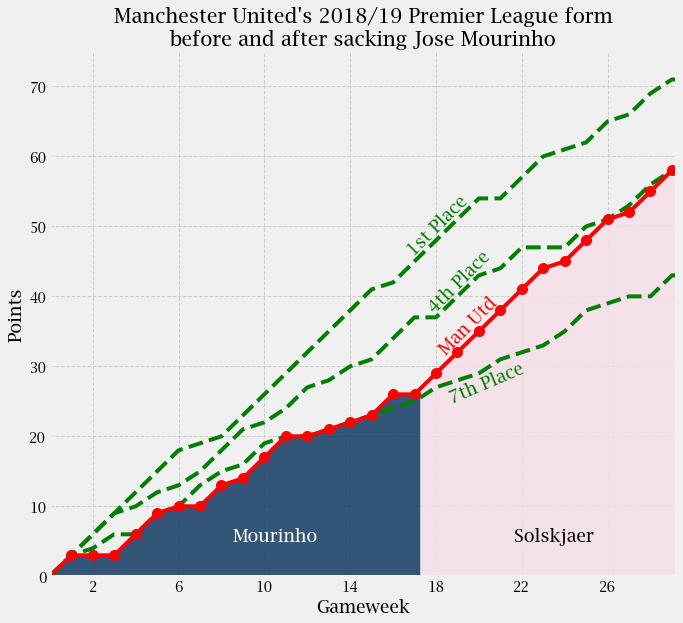

In [20]:
# Plot Man Utd's form before and after Solskjaer

# change some default styles/fonts
mpl.rc('font',family='Lucida Bright')
mpl.style.use('fivethirtyeight')

# make the matplotlib figure
ax = plt.figure(figsize=(10,9)).gca()

# plot the points totals for 1st, 4th and 7th place
plt.plot(matchday_rankpts[1],'g--',label='1st Place')
plt.plot(matchday_rankpts[4],'g--',label='4th Place')
plt.plot(matchday_rankpts[7],'g--',label='7th Place')

# plot Man Utd's points totals
plt.plot(matchday_pts['Manchester United'],'ro-',
         label='Man Utd',linewidth=4,markersize=10)

###### indicate mourinho and solskjaer's tenures
###### Mourinho until matchday 17, then Solskjaer from 18 onwards
# text labels
plt.text(10.5,5,'Mourinho',horizontalalignment='center',fontsize=18,color='white')
plt.text(23.5,5,'Solskjaer',horizontalalignment='center',fontsize=18)

# function to return man utd's points after each matchday, including
# interpolated points totals for non-integer values (between matchdays)
def manutd_pts(matchday):  
    try:
        return [manutd_pts(md) for md in matchday]

    except TypeError:
        if matchday==0:
            return 0

        elif round(matchday)==matchday:
            return matchday_pts.loc[matchday,'Manchester United']

        else:
            # linear fit to get non-integer values
            md_start = floor(matchday)
            md_end = ceil(matchday)

            pts_start = manutd_pts(md_start)
            pts_end = manutd_pts(md_end)

            gradient = (pts_end-pts_start)/(md_end-md_start)

            return (matchday-md_start)*gradient + pts_start

# shaded region for mourinho's tenure
section = np.arange(0, 17.5, 0.25)
plt.fill_between(section,manutd_pts(section),color='#032E5A',alpha=0.8)
# shaded region for solskjaer's tenure
section = np.arange(17.25, 30, 0.25)
plt.fill_between(section,manutd_pts(section),color='#F7DEE8',alpha=0.8)
######
######

# add labels to each line
plt.text(16.5,53,'1st Place',rotation=45,color='g',fontsize=18)
plt.text(17.5,45,'4th Place',rotation=45,color='g',fontsize=18)
plt.text(18.5,29,'7th Place',rotation=23,color='g',fontsize=18)
plt.text(18,38.5,'Man Utd',rotation=45,color='r',fontsize=18)

# add axis labels and title
plt.xlabel('Gameweek',fontsize=18)
plt.ylabel('Points',fontsize=18)
plt.title("Manchester United's 2018/19 Premier League form\nbefore and after sacking Jose Mourinho")

# set axis limits, tick labels etc.
plt.xlim([0,29.2])
plt.ylim([0,75])
plt.xticks(range(2,30,4),fontsize=14)
plt.yticks(fontsize=14)
ax.grid(linestyle='--')